# Photo-to-Cartoon Image Translation menggunakan Autoencoder dengan PyTorch

Notebook ini mendemonstrasikan implementasi **Autoencoder Konvolusional** (dengan struktur yang mirip U-Net) menggunakan PyTorch untuk tugas *Image-to-Image Translation*, khususnya mengubah **foto** menjadi gambar **kartun**.

Kami akan mencakup:
1. Penyiapan lingkungan PyTorch dan penentuan perangkat (CPU/GPU).
2. Memuat dataset `bhadresh-savani/photo-to-cartoon` dari Hugging Face Datasets.
3. Pra-pemrosesan data, termasuk normalisasi dan augmentasi data (*Horizontal Flip*).
4. Mendefinisikan arsitektur model `Autoencoder`.
5. Pelatihan model dengan fungsi *loss* MSE dan *scheduler* `ReduceLROnPlateau`.
6. Visualisasi hasil pelatihan dan gambar prediksi.
7. Menyimpan model untuk penggunaan di masa depan.


https://huggingface.co/datasets/bhadresh-savani/photo-to-cartoon

## 1. Penyiapan Lingkungan dan Perangkat

In [ ]:
!nvidia-smi

Fri Nov  7 11:18:06 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   46C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import torch
from torch import nn
import time
import matplotlib.pyplot as plt
from datasets import load_dataset
from PIL import Image
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split
from torchvision import transforms, utils
from torchsummary import summary

# Tentukan perangkat yang akan digunakan (GPU/CPU)
device = ""
if torch.cuda.is_available():
    print("Has gpu, using gpu")
    device = torch.device("cuda")
else:
    print("Only cpu, using cpu")
    device = torch.device("cpu")

# Konfigurasi global
image_size = 128
batch_size = 4

has gpu, using gpu


## 2. Pemuatan dan Eksplorasi Dataset

In [ ]:
# Muat dataset dari Hugging Face
print("Memuat dataset...")
photo_to_cartoon_raw_dataset = load_dataset("bhadresh-savani/photo-to-cartoon", data_dir="")
photo_to_cartoon_raw_dataset = photo_to_cartoon_raw_dataset["train"]
print("Dataset berhasil dimuat. Jumlah sampel: ", len(photo_to_cartoon_raw_dataset))

Memuat dataset...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Repo card metadata block was not found. Setting CardData to empty.


dataset_infos.json:   0%|          | 0.00/891 [00:00<?, ?B/s]

data/train-00000-of-00001-035009adcbbb5f(…):   0%|          | 0.00/311M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/76 [00:00<?, ? examples/s]

Dataset berhasil dimuat. Jumlah sampel:  76


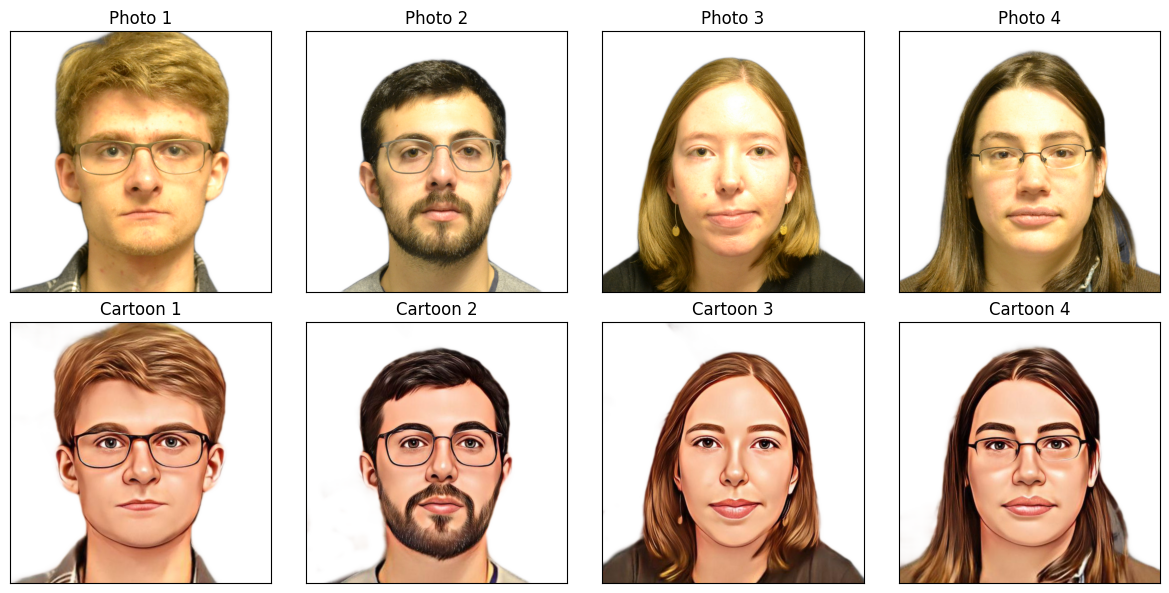

Ukuran gambar awal:  (2155, 2155) (609, 609)


In [ ]:
# Tampilkan beberapa contoh gambar dari dataset
imgnum = 4
imgrow = 2

plt.figure(figsize=(12, 6))
for i in range(imgnum):
    image = photo_to_cartoon_raw_dataset[i]["imageA"]  # Foto asli
    image2 = photo_to_cartoon_raw_dataset[i]["imageB"] # Gambar kartun (target)

    # Tampilkan Foto
    ax = plt.subplot(imgrow, imgnum, i + 1)
    plt.title("Photo {}".format(i + 1))
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])

    # Tampilkan Kartun
    ax = plt.subplot(imgrow, imgnum, i + imgnum + 1)
    plt.title("Cartoon {}".format(i + 1))
    plt.imshow(image2)
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.show()

print("Ukuran gambar awal: ", image.size, image2.size)

## 3. Pra-pemrosesan Data dan Augmentasi

In [ ]:
# Definisi Transformasi Gambar
# 1. Resize ke (image_size, image_size)
# 2. Konversi ke Tensor (nilai [0, 1])
# 3. Normalisasi ke rata-rata 0 dan standar deviasi 1 (nilai [-1, 1])
image_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5,), (0.5, 0.5, 0.5,))
])

# Transformasi untuk De-normalisasi (kembali ke nilai [0, 1] untuk visualisasi)
image_transform_denormalize = transforms.Compose([
    transforms.Normalize((0, 0, 0), (1/0.5, 1/0.5, 1/0.5,)),
    transforms.Normalize((-0.5, -0.5, -0.5,), (1, 1, 1))
])

### Kelas `ImageDataset` Kustom
Kelas kustom ini diperlukan untuk memproses pasangan gambar foto dan kartun, menerapkan transformasi, dan mengirimnya ke perangkat yang ditentukan.

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Pastikan gambar dalam format RGB
        photo_img = self.dataset[idx]["imageA"].convert("RGB")
        cartoon_img = self.dataset[idx]["imageB"].convert("RGB")

        if (self.transform):
            photo_img = self.transform(photo_img)
            cartoon_img = self.transform(cartoon_img)

        # Pindahkan tensor ke perangkat yang ditentukan (CPU/GPU)
        sample = {'photo_img': photo_img.to(device), 'cartoon_img': cartoon_img.to(device)}

        return sample

### Penerapan Augmentasi Data (Horizontal Flip)
Augmentasi dilakukan dengan menggabungkan dataset asli dengan dataset baru yang gambarnya di-*flip* secara horizontal. Ini menggandakan ukuran data pelatihan dan membantu generalisasi model.

Jumlah sampel dataset sebelum augmentasi:  76
Jumlah sampel dataset setelah augmentasi:  152
Shape Tensor Gambar:  torch.Size([3, 128, 128])


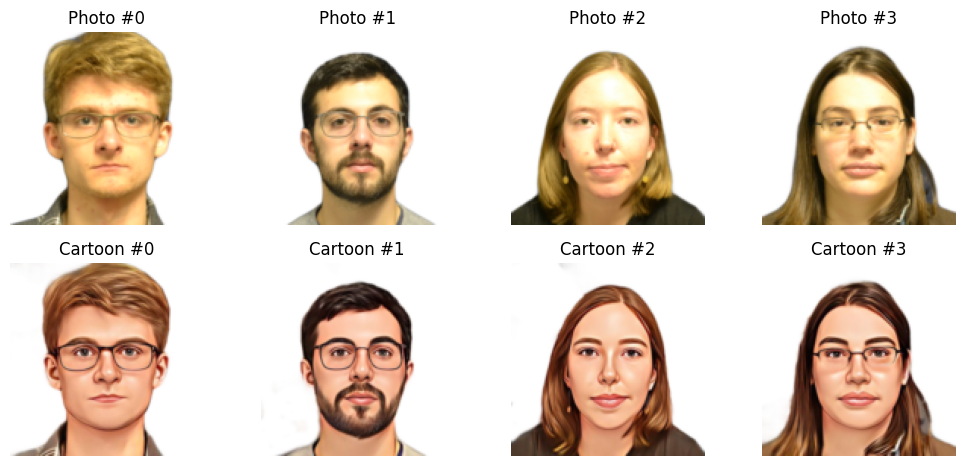

In [ ]:
# Dataset awal tanpa augmentasi
photo_to_cartoon_dataset_orig = ImageDataset(photo_to_cartoon_raw_dataset, image_transform)

# Transformasi untuk Horizontal Flip (probabilitas 1.0) diikuti dengan pra-pemrosesan standar
flip_h_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(1),
    image_transform
])

# Dataset hasil augmentasi (hanya Horizontal Flip)
ds_flip = ImageDataset(photo_to_cartoon_raw_dataset, flip_h_transform)

# Gabungkan dataset asli dan hasil augmentasi
photo_to_cartoon_dataset = ConcatDataset([photo_to_cartoon_dataset_orig, ds_flip])

print("Jumlah sampel dataset sebelum augmentasi: ", len(photo_to_cartoon_raw_dataset))
print("Jumlah sampel dataset setelah augmentasi: ", len(photo_to_cartoon_dataset))

# Contoh visualisasi sampel data setelah transformasi (termasuk augmentasi)
sample_size = 4
plt.figure(figsize=(10, 5))
for i, sample in enumerate(photo_to_cartoon_dataset):
    ax = plt.subplot(2, sample_size, i + 1)
    plt.tight_layout()
    ax.set_title('Photo #{}'.format(i))
    # De-normalisasi dan ubah dimensi (C, H, W) ke (H, W, C) untuk Matplotlib
    plt.imshow(image_transform_denormalize(sample["photo_img"].cpu().detach()).permute(1, 2, 0))
    ax.axis('off')

    ax = plt.subplot(2, sample_size, i + sample_size + 1)
    ax.set_title('Cartoon #{}'.format(i))
    plt.tight_layout()
    plt.imshow(image_transform_denormalize(sample["cartoon_img"].cpu().detach()).permute(1, 2, 0))
    ax.axis('off')

    if i == sample_size - 1:
        print("Shape Tensor Gambar: ", sample["photo_img"].shape)
        plt.show()
        break

### Pembagian Data dan DataLoader

In [ ]:
# Bagi dataset menjadi Training (90%) dan Validation (10%)
generator1 = torch.Generator().manual_seed(42)
train_size = int(0.9 * len(photo_to_cartoon_dataset))
val_size = len(photo_to_cartoon_dataset) - train_size
photo_to_cartoon_train_set, photo_to_cartoon_val_set = random_split(
    photo_to_cartoon_dataset,
    [train_size, val_size],
    generator=generator1
)

print("Jumlah sampel Training: ", len(photo_to_cartoon_train_set))
print("Jumlah sampel Validation: ", len(photo_to_cartoon_val_set))

Jumlah sampel Training:  136
Jumlah sampel Validation:  16


In [ ]:
# Buat DataLoader untuk Training dan Validation

torch.manual_seed(42)
photo_to_cartoon_dataloader = DataLoader(
    photo_to_cartoon_train_set,
    batch_size=batch_size,
    shuffle=True, # Acak data training
    num_workers=0 # Sesuaikan dengan kebutuhan sistem Anda
)

torch.manual_seed(42)
photo_to_cartoon_val_dataloader = DataLoader(
    photo_to_cartoon_val_set,
    batch_size=batch_size,
    shuffle=False, # Tidak perlu diacak untuk validasi
    num_workers=0
)

# Cek dimensi batch pertama
for i_batch, sample_batched in enumerate(photo_to_cartoon_dataloader):
    print("Shape tensor foto (Batch): ", sample_batched['photo_img'].size())
    print("Shape tensor kartun (Batch): ", sample_batched['cartoon_img'].size())
    break

for i_batch, sample_batched in enumerate(photo_to_cartoon_val_dataloader):
    print("Shape tensor foto (Val Batch): ", sample_batched['photo_img'].size())
    print("Shape tensor kartun (Val Batch): ", sample_batched['cartoon_img'].size())
    break

Shape tensor foto (Batch):  torch.Size([4, 3, 128, 128])
Shape tensor kartun (Batch):  torch.Size([4, 3, 128, 128])
Shape tensor foto (Val Batch):  torch.Size([4, 3, 128, 128])
Shape tensor kartun (Val Batch):  torch.Size([4, 3, 128, 128])


## 4. Definisi Model Autoencoder

Arsitektur yang digunakan adalah **Autoencoder Konvolusional** yang dirancang untuk tugas *image-to-image translation* (sering disebut sebagai varian U-Net tanpa *skip-connection* eksplisit, namun strukturnya tetap mencerminkan skema Encoder-Decoder).

Setiap langkah *downsampling* pada *Encoder* menggunakan `stride=2` dan setiap langkah *upsampling* pada *Decoder* menggunakan `ConvTranspose2d` dengan `stride=2` dan `output_padding=1` untuk mempertahankan resolusi spasial yang tepat. Resolusi gambar **128x128** diubah menjadi fitur spasial **4x4** di titik tengah model.

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()

        # ENCODER: 128 -> 64 -> 32 -> 16 -> 8 -> 4 (resolusi spasial)
        self.encoder = nn.Sequential(
            # Input: 3 x 128 x 128
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1), # 3x128x128 -> 64x128x128
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), # 128x64x64
            nn.ReLU(True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1), # 256x32x32
            nn.ReLU(True),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1), # 512x16x16
            nn.ReLU(True),
            nn.Conv2d(512, 1024, kernel_size=3, stride=2, padding=1), # 1024x8x8
            nn.ReLU(True),
            nn.Conv2d(1024, 1024, kernel_size=3, stride=2, padding=1), # 1024x4x4 (Latent space/Bottleneck)
        )

        # DECODER: 4 -> 8 -> 16 -> 32 -> 64 -> 128 (resolusi spasial)
        self.decoder = nn.Sequential(
            # Input: 1024 x 4 x 4
            nn.ConvTranspose2d(1024, 1024, kernel_size=3, stride=2, padding=1, output_padding=1), # 1024x8x8
            nn.ReLU(True),
            nn.ConvTranspose2d(1024, 512, kernel_size=3, stride=2, padding=1, output_padding=1), # 512x16x16
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1), # 256x32x32
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1), # 128x64x64
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1), # 64x128x128
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, kernel_size=3, padding=1), # 3x128x128 (Kernel size 3, stride 1 untuk output akhir)
            nn.Tanh() # Tanh mengembalikan output dalam rentang [-1, 1], sesuai dengan normalisasi input.
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

model = Autoencoder().to(device)

### Ringkasan Model (TorchSummary)
Kita dapat menggunakan `torchsummary` untuk melihat arsitektur model secara ringkas dan memastikan dimensi output di setiap lapisan sudah benar.

In [ ]:
input_shape = (3, image_size, image_size)
print("Input shape model:", input_shape)
# summary akan menampilkan total parameter dan output shape setiap layer
summary(model, input_shape)

Input shape model: (3, 128, 128)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
              ReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3          [-1, 128, 64, 64]          73,856
              ReLU-4          [-1, 128, 64, 64]               0
            Conv2d-5          [-1, 256, 32, 32]         295,168
              ReLU-6          [-1, 256, 32, 32]               0
            Conv2d-7          [-1, 512, 16, 16]       1,180,160
              ReLU-8          [-1, 512, 16, 16]               0
            Conv2d-9           [-1, 1024, 8, 8]       4,719,616
             ReLU-10           [-1, 1024, 8, 8]               0
           Conv2d-11           [-1, 1024, 4, 4]       9,438,208
  ConvTranspose2d-12           [-1, 1024, 8, 8]       9,438,208
             ReLU-13           [-1, 1024, 8, 8]               0
  Conv

## 5. Konfigurasi Pelatihan dan Pelatihan Model

In [ ]:
# Fungsi Loss (Mean Squared Error: untuk mengukur perbedaan piksel)
loss_function = nn.MSELoss()

# Optimizer (Adam)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

# Scheduler untuk mengurangi Learning Rate saat Val Loss tidak membaik
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)

In [ ]:
epoch = 150
losses = []
val_losses = []
eval_outputs = []

# Parameter Early Stopping
MAX_NOT_LEARNING = 10
not_learning = 0
min_val_loss = float('inf')

print("Memulai pelatihan...")
start_global = time.time()

for i in range(epoch):
    start_epoch = time.time()
    # --- Tahap Training ---
    model.train()
    for i_batch, sample_batched in enumerate(photo_to_cartoon_dataloader):
        photo_imgs = sample_batched["photo_img"]
        cartoon_imgs = sample_batched["cartoon_img"]

        optimizer.zero_grad()
        outputs = model(photo_imgs)
        loss_model = loss_function(outputs, cartoon_imgs)

        loss_model.backward()
        optimizer.step()

    # Simpan Training Loss terakhir
    current_train_loss = loss_model.item()
    losses.append(current_train_loss)

    # --- Tahap Validasi ---
    model.eval()
    current_val_loss = 0
    temp_eval_outputs = []
    with torch.no_grad():
        for i_batch, sample_batched in enumerate(photo_to_cartoon_val_dataloader):
            outputs = model(sample_batched["photo_img"])
            val_loss = loss_function(outputs, sample_batched["cartoon_img"])
            current_val_loss = val_loss.item()

            # Simpan output prediksi untuk visualisasi
            for out in outputs:
                temp_eval_outputs.append(out.cpu().detach())

            # Hanya proses satu batch dari validation set per epoch untuk efisiensi
            break

    val_losses.append(current_val_loss)
    eval_outputs.append(temp_eval_outputs)

    # Update Learning Rate Scheduler
    scheduler.step(current_val_loss)

    time_taken = time.time() - start_epoch
    print("Epoch {} | Loss: {:.5f} | Val_Loss: {:.5f} | Waktu: {:.3f}s".format(
        i + 1, current_train_loss, current_val_loss, time_taken))

    # Logika Early Stopping berdasarkan Val_Loss
    if current_val_loss < min_val_loss:
        min_val_loss = current_val_loss
        not_learning = 0
        # Opsi: Simpan model terbaik di sini
    else:
        not_learning += 1

    if not_learning >= MAX_NOT_LEARNING:
        print(f"\nEarly stopping diaktifkan setelah {i+1} epoch (Val Loss tidak membaik selama {MAX_NOT_LEARNING} epoch).")
        break

print(f"\nPelatihan selesai. Total waktu: {(time.time() - start_global):.2f}s")

Memulai pelatihan...
Epoch 1 | Loss: 0.25819 | Val_Loss: 0.23222 | Waktu: 31.415s
Epoch 2 | Loss: 0.17851 | Val_Loss: 0.17400 | Waktu: 31.531s
Epoch 3 | Loss: 0.15707 | Val_Loss: 0.11444 | Waktu: 31.067s
Epoch 4 | Loss: 0.09295 | Val_Loss: 0.08649 | Waktu: 30.950s
Epoch 5 | Loss: 0.09317 | Val_Loss: 0.08806 | Waktu: 30.515s
Epoch 6 | Loss: 0.09627 | Val_Loss: 0.07237 | Waktu: 31.394s
Epoch 7 | Loss: 0.07196 | Val_Loss: 0.08475 | Waktu: 30.651s
Epoch 8 | Loss: 0.07425 | Val_Loss: 0.07978 | Waktu: 31.204s
Epoch 9 | Loss: 0.06779 | Val_Loss: 0.07058 | Waktu: 30.475s
Epoch 10 | Loss: 0.07874 | Val_Loss: 0.07126 | Waktu: 31.173s
Epoch 11 | Loss: 0.06578 | Val_Loss: 0.06125 | Waktu: 30.594s
Epoch 12 | Loss: 0.07008 | Val_Loss: 0.06367 | Waktu: 31.130s
Epoch 13 | Loss: 0.06494 | Val_Loss: 0.07318 | Waktu: 30.544s
Epoch 14 | Loss: 0.05834 | Val_Loss: 0.06909 | Waktu: 31.178s
Epoch 15 | Loss: 0.05845 | Val_Loss: 0.07947 | Waktu: 30.919s
Epoch 16 | Loss: 0.05820 | Val_Loss: 0.07386 | Waktu: 30.9

## 6. Visualisasi Hasil

### Plot Kurva Loss

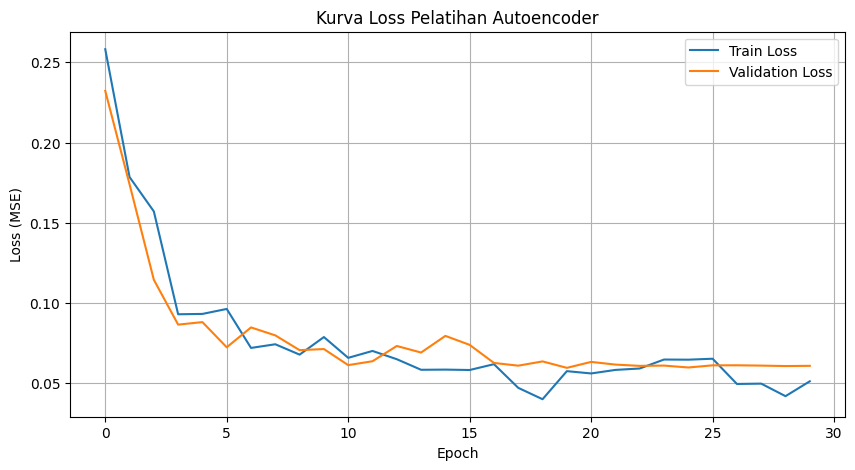

In [ ]:
plt.figure(figsize=(10, 5))
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.plot(losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Kurva Loss Pelatihan Autoencoder")
plt.legend()
plt.grid(True)
plt.show()

### Visualisasi Gambar Prediksi

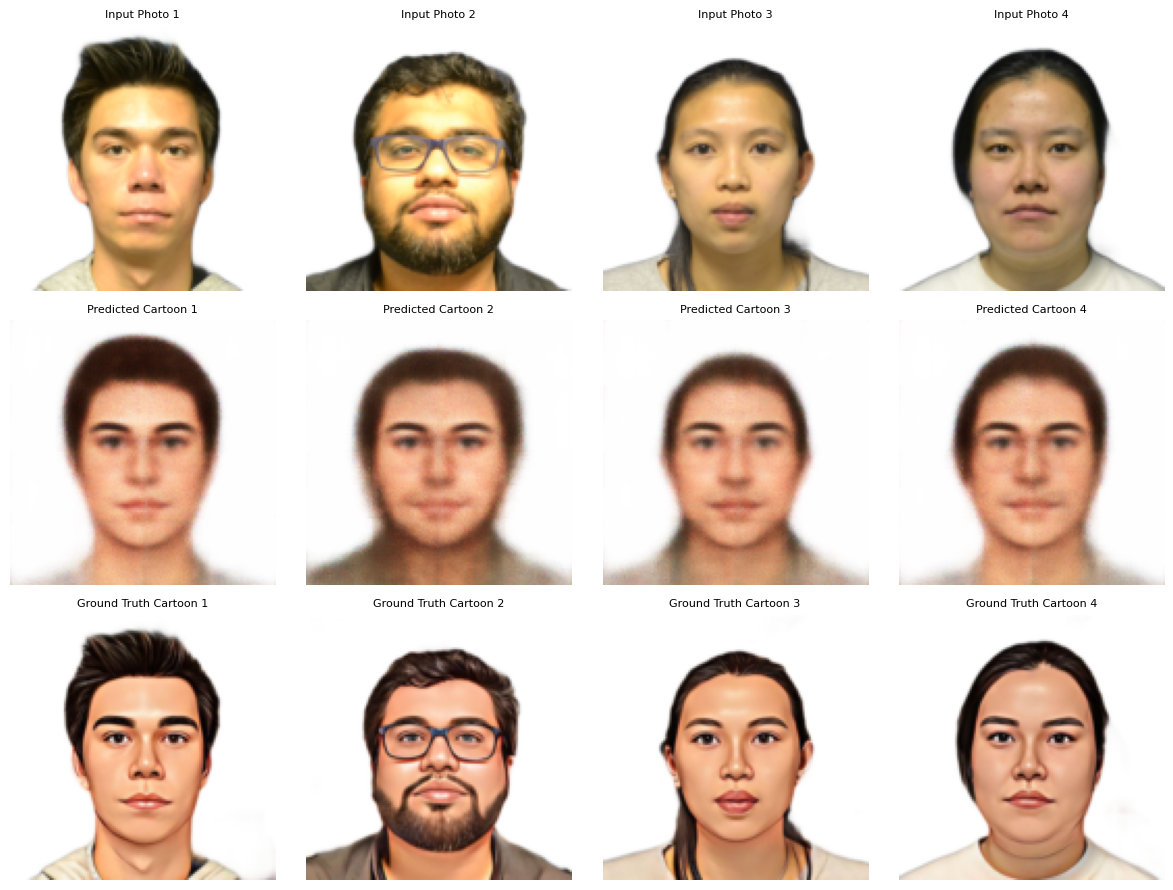

In [ ]:
# Ambil satu batch pertama dari data validasi untuk perbandingan
photo_to_cartoon_val_dataloader_iter = iter(photo_to_cartoon_val_dataloader)
sample_batched_val = next(photo_to_cartoon_val_dataloader_iter)
photo_imgs = sample_batched_val["photo_img"]
cartoon_imgs = sample_batched_val["cartoon_img"]

# Lakukan prediksi pada batch validasi
model.eval()
with torch.no_grad():
    outputs = model(photo_imgs)

sample_size = 4
fontsize = 8

plt.figure(figsize=(12, 9))

for i in range(sample_size):
    # 1. Gambar Foto (Input)
    ax = plt.subplot(3, sample_size, i + 1)
    plt.title("Input Photo {}".format(i + 1), fontsize=fontsize)
    img_in = image_transform_denormalize(photo_imgs[i].cpu().detach()).permute(1, 2, 0)
    plt.imshow(img_in)
    ax.axis("off")

    # 2. Gambar Prediksi (Output Model)
    ax = plt.subplot(3, sample_size, i + sample_size + 1)
    plt.title("Predicted Cartoon {}".format(i + 1), fontsize=fontsize)
    img_out = image_transform_denormalize(outputs[i].cpu().detach()).permute(1, 2, 0)
    # Gunakan .numpy() pada tensor PyTorch untuk visualisasi Matplotlib
    plt.imshow(img_out.numpy())
    ax.axis("off")

    # 3. Gambar Kartun (Ground Truth)
    ax = plt.subplot(3, sample_size, i + (sample_size * 2) + 1)
    plt.title("Ground Truth Cartoon {}".format(i + 1), fontsize=fontsize)
    img_gt = image_transform_denormalize(cartoon_imgs[i].cpu().detach()).permute(1, 2, 0)
    plt.imshow(img_gt)
    ax.axis("off")

plt.tight_layout()
plt.show()

## 7. Penyimpanan Model

Penting untuk menyimpan model terlatih agar dapat digunakan kembali tanpa perlu pelatihan ulang. Kami akan menyimpan model dalam beberapa format standar PyTorch:

* **Model Lengkap (Full Model):** Menyimpan keseluruhan objek model, termasuk arsitektur dan parameter (*disarankan untuk saat ini*).
* **State Dictionary:** Hanya menyimpan parameter terlatih (bobot) (*disarankan untuk produksi*).
* **TorchScript:** Format yang dioptimalkan untuk inferensi dan deployment di lingkungan non-Python.

In [ ]:
# Menyimpan hanya State Dictionary (lebih ringkas dan fleksibel)
torch.save({
    'epoch': i + 1, # epoch terakhir sebelum break
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': losses[-1],
}, "PhotoToCartoonAutoencoder_state_dict.pt")
print("Model State Dictionary berhasil disimpan.")

# Menyimpan model lengkap (termasuk arsitektur)
torch.save(model, "PhotoToCartoonAutoencoder_full.pt")
print("Model lengkap berhasil disimpan.")

# Menyimpan sebagai TorchScript untuk deployment
model.to('cpu') # Pindahkan ke CPU sebelum scripting jika model di GPU
model_scripted = torch.jit.script(model)
model_scripted.save("PhotoToCartoonAutoencoder_scripted.pt")
print("Model TorchScript berhasil disimpan.")
model.to(device) # Kembalikan ke perangkat awal

Model State Dictionary berhasil disimpan.
Model lengkap berhasil disimpan.
Model TorchScript berhasil disimpan.


Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(512, 1024, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(1024, 1024, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(1024, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(512, 256, kernel_size=(3, 3),

In [ ]:
import torch
from torch import nn
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# 2. TENTUKAN PERANGKAT DAN INISIALISASI MODEL
# Asumsikan 'device' sudah terdefinisi dari sel-sel awal (cuda atau cpu)
model = Autoencoder().to(device)

# 3. MUAT BOBOT DARI FILE *.pt
MODEL_PATH = "/content/PhotoToCartoonAutoencoder_state_dict.pt"

try:
    # Memuat State Dictionary
    checkpoint = torch.load(MODEL_PATH, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Bobot model berhasil dimuat dari '{MODEL_PATH}'.")

except Exception as e:
    print(f"GAGAL memuat model. Pastikan file '{MODEL_PATH}' ada di direktori yang sama. Error: {e}")

# Set model ke mode evaluasi
model.eval()
print("Model siap untuk inferensi.")

✅ Bobot model berhasil dimuat dari '/content/PhotoToCartoonAutoencoder_state_dict.pt'.
Model siap untuk inferensi.


In [ ]:
image_size = 128

# Transformasi Input (Harus SAMA dengan saat pelatihan!)
test_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5,), (0.5, 0.5, 0.5,))
])

# Transformasi Output (De-normalisasi) untuk visualisasi
image_transform_denormalize = transforms.Compose([
    transforms.Normalize((0, 0, 0), (1/0.5, 1/0.5, 1/0.5,)),
    transforms.Normalize((-0.5, -0.5, -0.5,), (1, 1, 1))
])

print("Transformasi siap.")

Transformasi siap.


Foto berhasil dimuat. Input Tensor shape: torch.Size([1, 3, 128, 128])


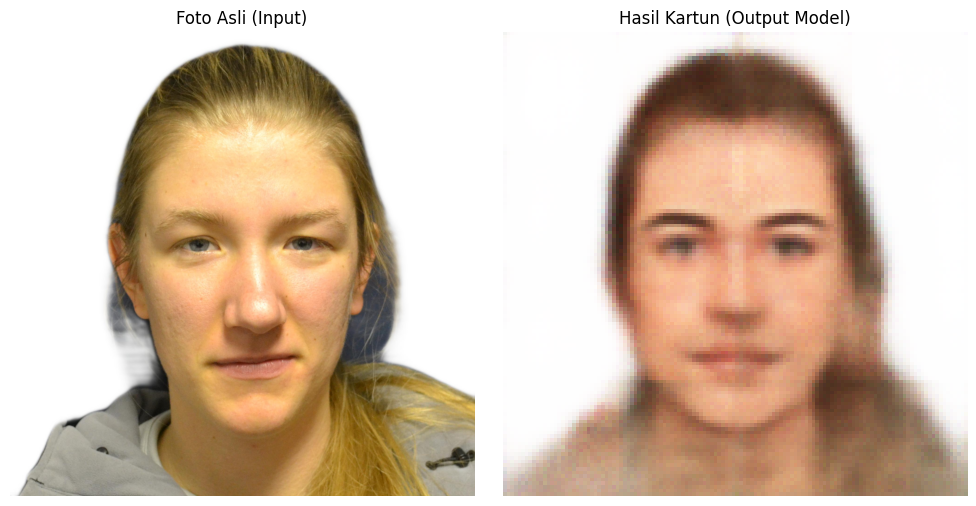

In [ ]:
test_image_path = "/content/sample.jpg"

try:
    # 1. Muat Foto
    test_img_pil = Image.open(test_image_path).convert('RGB')

    # 2. Pra-pemrosesan: Transformasi dan tambahkan dimensi batch (1, 3, 128, 128)
    input_tensor = test_transform(test_img_pil).unsqueeze(0).to(device)

    print(f"Foto berhasil dimuat. Input Tensor shape: {input_tensor.shape}")

    # 3. Prediksi Model (Inference)
    with torch.no_grad():
        output_tensor = model(input_tensor)

    # 4. Pasca-pemrosesan: De-normalisasi dan konversi ke NumPy
    output_tensor_cpu = output_tensor.squeeze(0).cpu().detach()
    predicted_image_numpy = image_transform_denormalize(output_tensor_cpu).permute(1, 2, 0).numpy()
    predicted_image_numpy = predicted_image_numpy.clip(0, 1)

    # 5. Visualisasi
    plt.figure(figsize=(10, 5))

    # Tampilkan Foto Asli
    plt.subplot(1, 2, 1)
    plt.title("Foto Asli (Input)")
    plt.imshow(test_img_pil)
    plt.axis('off')

    # Tampilkan Hasil Kartun
    plt.subplot(1, 2, 2)
    plt.title("Hasil Kartun (Output Model)")
    plt.imshow(predicted_image_numpy)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print(f"ERROR: File foto tidak ditemukan di '{test_image_path}'. Pastikan path sudah benar.")
except Exception as e:
    print(f"Terjadi error saat memproses gambar: {e}")